In [59]:
import torch
import torch.nn as nn
import torch.optim
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import MultiStepLR
from torchvision.transforms import Compose
from models.fewshot import FewShotSeg
from dataloaders.customized import voc_fewshot, coco_fewshot
from dataloaders.transforms import RandomMirror, Resize, ToTensorNormalize
from util.utils import set_seed, CLASS_LABELS
import torch.optim as optim
import matplotlib.pyplot as plt
import cv2
import numpy as np

In [107]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
    #set the device to gpu0
    torch.cuda.set_device(device=0)
else:
    device = torch.device('cpu')

In [108]:
input_size = (417, 417)
batch_size=1
steps=30000
lambda_PAR=1

In [109]:
#Get the dataset functions from here
dataset_name="VOC"
if dataset_name == 'VOC':
    gen_dataset = voc_fewshot
    data_dir='../../data/Pascal/VOCdevkit/VOC2012/'
    data_split='trainaug'
elif dataset_name == 'COCO':
    gen_dataset = coco_fewshot
    data_dir='../../data/COCO/'
    data_split='train'
# else: 
#     dataset=cityscape_fewshot

labels = CLASS_LABELS[dataset_name][0]
transforms = Compose([Resize(size=input_size),
                        RandomMirror()])
dataset = gen_dataset(
    base_dir=data_dir,
    split=data_split,
    transforms=transforms,
    to_tensor=ToTensorNormalize(),
    labels=labels,
    max_iters=batch_size*steps,
    n_ways=1,
    n_shots=1,
    n_queries=1
)

train_loader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=1,
    pin_memory=True,
    drop_last=True
)

In [110]:
model_path= "./misc/fewshot_snapshot.pth"

In [111]:
print_every=100
def train_model(model, optimizer, scheduler ,epochs=1):

    train_loss={}
    #lossfn=nn.CosineEmbeddingLoss(margin=0,reduction="mean")
    lossfn=nn.MSELoss()
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    train_loss["loss_query"]=0
    train_loss["loss_PAR"]=0
    for e in range(epochs):
        lossq=0
        losspar=0
        for t,samples in enumerate(train_loader):
            
           #get a list of support images ( Sx W x H x W)
            support_img=[[shot.cuda() for shot in way]
                          for way in samples['support_images']]
            fg_mask=[[shot[f'fg_mask'].float().cuda() for shot in way]
                           for way in samples['support_mask']]
            bg_mask=[[shot[f'bg_mask'].float().cuda() for shot in way]
                           for way in samples['support_mask']]
            query_img= [query.cuda()
                        for query in samples['query_images']]

            query_gt = torch.cat([queryGT.long().cuda()
                        for queryGT in samples['query_labels']], dim=0)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            #get the predicted query and the Prototype alignment loss
            pred_query,lossPAR= model(support_img,fg_mask,bg_mask,query_img)

            lossQ= criterion(pred_query,query_gt)

            loss = lossQ+ lossPAR * lambda_PAR
            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            scheduler.step()

            lossq+=lossQ.detach().cpu().numpy()
            losspar+=lossPAR

            torch.save(model.state_dict(),model_path)

            if (t+1) % print_every == 0:
                print('Epoch %d, Iteration %d, loss = %.8f' % (e, t+1, (lossq/(t+1))))
                print('Epoch %d, Iteration %d, loss = %.8f' % (e, t+1, (losspar/(t+1))))

        train_loss["loss_query"]=lossq/len(train_loader)
        train_loss["loss_PAR"]=losspar/len(train_loader)

    return (train_loss)

In [6]:
#cfg True means align is on
learning_rate=1e-3
milestones= [steps//3,steps//2,steps]
model = FewShotSeg(cfg={'align': True})
optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate,momentum=0.9,weight_decay=0.00005)
scheduler = MultiStepLR(optimizer, milestones=milestones, gamma=0.1)
criterion = nn.CrossEntropyLoss(ignore_index=255)

Using cache found in /home/prasad/.cache/torch/hub/pytorch_vision_v0.10.0


In [7]:
train_loss=train_model(model, optimizer, scheduler ,epochs=1)

/home/prasad/anaconda3/envs/aec/lib/python3.9/site-packages/torchvision/transforms/functional.py:423: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


Epoch 0, Iteration 99, loss = 0.62356757
Epoch 0, Iteration 99, loss = 0.48367080
Epoch 0, Iteration 199, loss = 0.60183225
Epoch 0, Iteration 199, loss = 0.49071583
Epoch 0, Iteration 299, loss = 0.59305005
Epoch 0, Iteration 299, loss = 0.47925672
Epoch 0, Iteration 399, loss = 0.58138996
Epoch 0, Iteration 399, loss = 0.47492394
Epoch 0, Iteration 499, loss = 0.57395365
Epoch 0, Iteration 499, loss = 0.45595059
Epoch 0, Iteration 599, loss = 0.56664784
Epoch 0, Iteration 599, loss = 0.45231929
Epoch 0, Iteration 699, loss = 0.56497097
Epoch 0, Iteration 699, loss = 0.44813687
Epoch 0, Iteration 799, loss = 0.55759155
Epoch 0, Iteration 799, loss = 0.44269976
Epoch 0, Iteration 899, loss = 0.55541185
Epoch 0, Iteration 899, loss = 0.43652001
Epoch 0, Iteration 999, loss = 0.54858786
Epoch 0, Iteration 999, loss = 0.43148163
Epoch 0, Iteration 1099, loss = 0.55058380
Epoch 0, Iteration 1099, loss = 0.42617375
Epoch 0, Iteration 1199, loss = 0.54958481
Epoch 0, Iteration 1199, loss = 0

In [100]:
model_path= "./misc/fewshot_3k.pth"
torch.save(model.state_dict(),model_path)

In [101]:
model_eval=FewShotSeg(cfg={"align":True})
model_eval.load_state_dict(torch.load(model_path))

Using cache found in /home/prasad/.cache/torch/hub/pytorch_vision_v0.10.0


<All keys matched successfully>

In [102]:
#Prediction 
idx=0
iterator=iter(train_loader)
sample=iterator.next()
support_img=[[shot.cuda() for shot in way]
                for way in sample['support_images']]
fg_mask=[[shot[f'fg_mask'].float().cuda() for shot in way]
                for way in sample['support_mask']]
bg_mask=[[shot[f'bg_mask'].float().cuda() for shot in way]
                for way in sample['support_mask']]
query_img= [query.cuda()
            for query in sample['query_images']]
query_gt = torch.cat([queryGT.long().cuda()
                        for queryGT in sample['query_labels']], dim=0)

/home/prasad/anaconda3/envs/aec/lib/python3.9/site-packages/torchvision/transforms/functional.py:423: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


In [103]:
model.eval()
with torch.no_grad():
    pred_query,lossPAR= model(support_img,fg_mask,bg_mask,query_img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


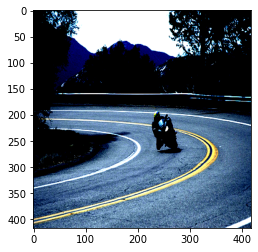

In [104]:
test=query_img[0][0].cpu().numpy()

test=np.transpose(test,(1,2,0))
plt.figure()
plt.imshow(test)

torch.Size([1, 2, 417, 417])


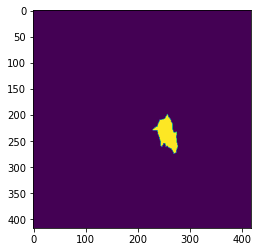

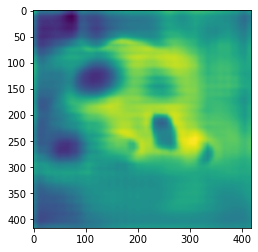

In [106]:
plt.figure()
plt.imshow(query_gt.cpu().numpy()[0,:,:])
plt.figure()
plt.imshow(pred_query.cpu().numpy()[0,1,:,:])
print(pred_query.shape)